# Anscombe's Quartet — Analysis

1. Descriptive statistics (mean, SD, SEM)
2. Regression analysis (slope, intercept, R², p-value, SE)
3. Scatter plots with regression line + 95 % confidence band
4. Mean ± SEM bar chart
5. Residual plots
6. One-way ANOVA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as sp_stats

%matplotlib inline

df = pd.read_csv('anscombe_quartet.tsv', sep='\t')
datasets = ['I', 'II', 'III', 'IV']
colors   = ['#2176ae', '#e07b39', '#3ba35d', '#9b59b6']
df.head()

,dataset,x,y
0,I,10,8.04
1,I,8,6.95
2,I,13,7.58
3,I,9,8.81
4,I,11,8.33


## 1. Descriptive Statistics — mean, SD, SEM per group

In [2]:
rows = []
for grp, sub in df.groupby('dataset', sort=False):
    for col in ['x', 'y']:
        vals = sub[col]
        n    = len(vals)
        mean = vals.mean()
        sd   = vals.std(ddof=1)
        sem  = sd / np.sqrt(n)
        rows.append({'group': grp, 'variable': col, 'n': n,
                     'mean': round(mean, 4),
                     'SD':   round(sd,   4),
                     'SEM':  round(sem,  4)})

desc_stats = pd.DataFrame(rows)
desc_stats

,group,variable,n,mean,SD,SEM
0,I,x,11,9.0000,3.3166,1.0000
1,I,y,11,7.5009,2.0316,0.6125
2,II,x,11,9.0000,3.3166,1.0000
3,II,y,11,7.5009,2.0317,0.6126
4,III,x,11,9.0000,3.3166,1.0000
5,III,y,11,7.5000,2.0304,0.6122
6,IV,x,11,9.0000,3.3166,1.0000
7,IV,y,11,7.5009,2.0306,0.6122


## 2. Regression Analysis

In [3]:
reg_rows = []
for grp in datasets:
    sub = df[df['dataset'] == grp]
    x, y = sub['x'].values, sub['y'].values
    slope, intercept, r, p, se_slope = sp_stats.linregress(x, y)
    n = len(x)
    # SE of intercept
    se_int = se_slope * np.sqrt((x**2).mean())
    reg_rows.append({
        'group':      grp,
        'slope':      round(slope,     4),
        'SE(slope)':  round(se_slope,  4),
        'intercept':  round(intercept, 4),
        'SE(int)':    round(se_int,    4),
        'R':          round(r,         4),
        'R²':         round(r**2,      4),
        'p(slope)':   round(p,         4),
    })

reg_stats = pd.DataFrame(reg_rows)
reg_stats

,group,slope,SE(slope),intercept,SE(int),R,R²,p(slope)
0,I,0.5001,0.1179,3.0001,1.1247,0.8164,0.6665,0.0022
1,II,0.5000,0.1180,3.0009,1.1253,0.8162,0.6662,0.0022
2,III,0.4997,0.1179,3.0025,1.1245,0.8163,0.6663,0.0022
3,IV,0.4999,0.1178,3.0017,1.1239,0.8165,0.6667,0.0022


All four groups produce **the same regression equation** (slope ≈ 0.50, intercept ≈ 3.00, R² ≈ 0.67) — yet the scatter plots will show they should not all be modelled with a straight line.

## 3. Scatter Plots with Regression Line and 95 % Confidence Band

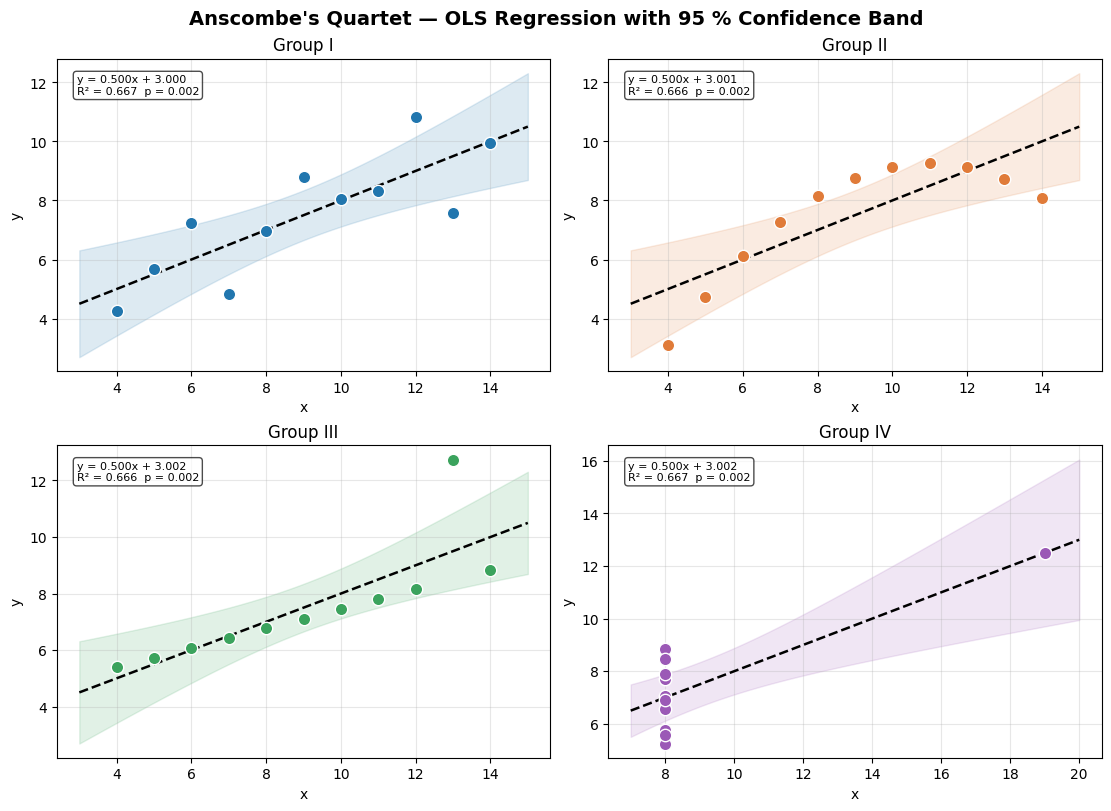

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
fig.suptitle("Anscombe's Quartet — OLS Regression with 95 % Confidence Band",
             fontsize=14, fontweight='bold')

for ax, grp, col in zip(axes.flat, datasets, colors):
    sub = df[df['dataset'] == grp]
    x, y = sub['x'].values, sub['y'].values
    n = len(x)

    slope, intercept, r, p, se_slope = sp_stats.linregress(x, y)
    x_line = np.linspace(x.min() - 1, x.max() + 1, 300)
    y_line = slope * x_line + intercept

    # 95 % confidence band via t * SE of prediction mean
    x_mean = x.mean()
    ss_x   = ((x - x_mean) ** 2).sum()
    y_hat  = slope * x + intercept
    mse    = ((y - y_hat) ** 2).sum() / (n - 2)
    t_crit = sp_stats.t.ppf(0.975, df=n - 2)
    se_band = np.sqrt(mse * (1/n + (x_line - x_mean)**2 / ss_x))
    ci_upper = y_line + t_crit * se_band
    ci_lower = y_line - t_crit * se_band

    ax.fill_between(x_line, ci_lower, ci_upper, color=col, alpha=0.15, label='95 % CI')
    ax.plot(x_line, y_line, color='black', lw=1.8, ls='--')
    ax.scatter(x, y, color=col, edgecolors='white', s=80, zorder=4)
    ax.set_title(f'Group {grp}', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.text(0.04, 0.95,
            f'y = {slope:.3f}x + {intercept:.3f}\nR² = {r**2:.3f}  p = {p:.3f}',
            transform=ax.transAxes, va='top', fontsize=8,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.show()

## 4. Mean ± SEM Bar Chart for y

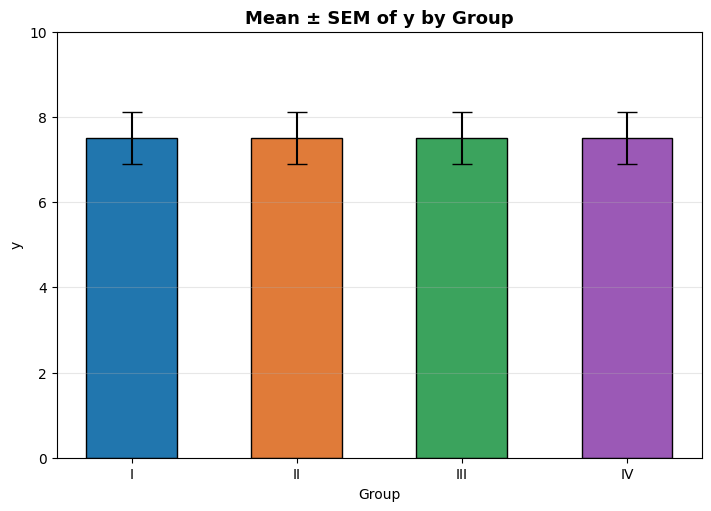

In [5]:
y_stats = desc_stats[desc_stats['variable'] == 'y'].copy()

fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
ax.bar(y_stats['group'], y_stats['mean'], yerr=y_stats['SEM'],
       color=colors, edgecolor='black', capsize=7, width=0.55)
ax.set_title("Mean ± SEM of y by Group", fontsize=13, fontweight='bold')
ax.set_xlabel('Group')
ax.set_ylabel('y')
ax.set_ylim(0, 10)
ax.grid(axis='y', alpha=0.3)
plt.show()

The bar chart shows all four groups as nearly identical — illustrating what gets **hidden** by summary statistics alone.

## 5. Residual Plots

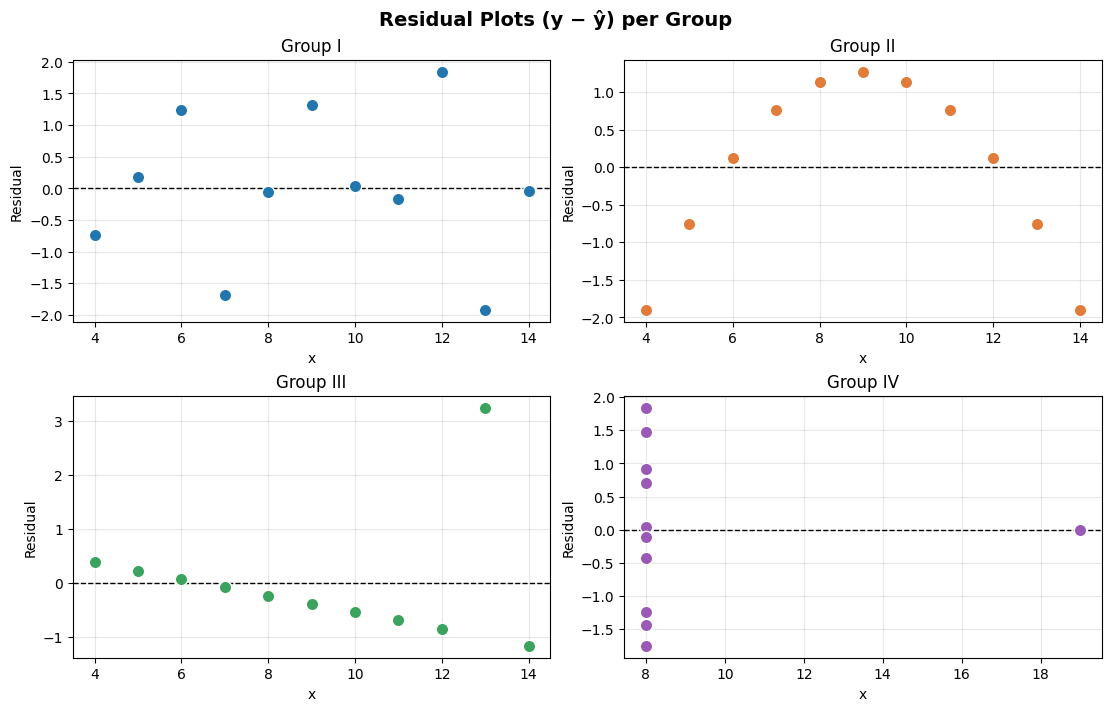

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7), constrained_layout=True)
fig.suptitle("Residual Plots (y − ŷ) per Group", fontsize=14, fontweight='bold')

for ax, grp, col in zip(axes.flat, datasets, colors):
    sub = df[df['dataset'] == grp]
    x, y = sub['x'].values, sub['y'].values
    slope, intercept, *_ = sp_stats.linregress(x, y)
    residuals = y - (slope * x + intercept)

    ax.axhline(0, color='black', lw=1, ls='--')
    ax.scatter(x, residuals, color=col, edgecolors='white', s=80, zorder=3)
    ax.set_title(f'Group {grp}', fontsize=12)
    ax.set_xlabel('x')
    ax.set_ylabel('Residual')
    ax.grid(True, alpha=0.3)

plt.show()

## 6. One-Way ANOVA

In [7]:
groups_y = [df[df['dataset'] == g]['y'].values for g in datasets]
f_stat, p_val = sp_stats.f_oneway(*groups_y)

pd.DataFrame([{
    'F statistic': round(f_stat, 4),
    'p value':     round(p_val,  4),
    'Significant (α=0.05)': 'Yes' if p_val <= 0.05 else 'No'
}])

,F statistic,p value,Significant (α=0.05)
0,0.0,1.0,No


ANOVA finds **no significant difference** between group means (p > 0.05) — by design.

### Takeaway
| Group | Pattern | Linear model appropriate? |
|-------|---------|---------------------------|
| I     | Linear with natural scatter | Yes |
| II    | Curved (quadratic) — residuals show clear arc | No |
| III   | Linear + one high-leverage outlier inflating slope | Questionable |
| IV    | All x = 8 except one point at x = 19; regression entirely outlier-driven | No |

Identical regression equations, R², and ANOVA across all four groups — yet the data are structurally incomparable. **Always visualize your data.**